In [1]:
import os
import copy
import string
import heapq
import numpy as np
from word2number import w2n
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

# java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000

import corenlp
os.environ["CORENLP_HOME"] = "./NaturalLanguagePipeline\lib\stanford-corenlp-4.1.0"

relationPriority = {
    "fixed": 9,
    "conj:verb": 10,
    "amod": 10,
    "compound": 10,
    "nummod": 10,
    "expl": 10,
    "det": 15,
    "cc": 15,
    "conj:adj": 16,
    "conj:np": 16,
    "appos": 16,
    "acl:relcl": 16,
    "acl": 16,
    "acl-other": 16,
    "cop": 20,
    "obj": 20,
    "obj:wh": 20,
    "mark": 20,
    "aux:pass": 30,
    "aux": 30,
    "xcomp": 30,
    "nmod:poss": 40,
    "nmod:npmod": 40,
    "nmod:tmod": 40,
    "nmod:count": 40,
    "nmod": 40,
    "obl": 40,
    "obl:npmod": 40,
    "advmod": 40,
    "advmod:count": 40,
    "advcl": 40,
    "ccomp": 40,
    "dep": 45,
    "conj": 45,
    "conj:vp": 45,
    "nsubj": 60,
    "nsubj:pass": 60,
    "nsubj:wh": 60,
    "case": 70,
    "conj:sent": 80,
    "punct": 90,
    "root": 90,
}

In [3]:
#https://immense-dawn-54795.herokuapp.com/

from nltk.parse.corenlp import *

dep_parser = CoreNLPDependencyParser(url='https://immense-dawn-54795.herokuapp.com/:')
parse = dep_parser.raw_parse( 'The quick brown fox jumps over the lazy dog.')


HTTPError: 503 Server Error: Service Unavailable for url: https://immense-dawn-54795.herokuapp.com/:?properties=%7B%22outputFormat%22%3A+%22json%22%2C+%22annotators%22%3A+%22tokenize%2Cpos%2Clemma%2Cssplit%2Cdepparse%22%2C+%22ssplit.eolonly%22%3A+%22true%22%2C+%22tokenize.whitespace%22%3A+%22false%22%7D

In [2]:
def dependencyParse(text):
    parse_trees = []
    
    with corenlp.CoreNLPClient(annotators="tokenize ssplit pos lemma depparse".split()) as client:
        ann = client.annotate(text)

        sentence = ann.sentence[0]
        words = {}
        for token in sentence.token:
            if not token.word in string.punctuation:
                words[token.tokenEndIndex] = [token.word, token.pos]
            
        deps = []
        targets = {}
        nodes = sentence.basicDependencies.node
        for edge in sentence.basicDependencies.edge:
            if edge.dep != "punct":
                targets[edge.target] = edge.dep
                deps.append([edge.dep, edge.target, edge.source])

        postags = {}
        maxroot = 0
        root = ""
        rooted = False
        
        for wordid in words:
            word = words[wordid][0]
            if not wordid in targets:
                if wordid > maxroot:
                    maxroot = wordid
                    root = wordid
                    rooted = True
                elif not rooted and "acl" in targets[wordid]:
                    maxroot = wordid
                    root = wordid
                    rooted = True
            postags[word] = [wordid, words[wordid][1]]
        deps.append(['root', root, 'root'])
    return deps, postags, words

In [3]:
class BinaryDependencyTree:
    def __init__(self, val, parent, left, right, key, wid=None, npos=None):
        self.val = val
        self.parent = parent
        self.left = left
        self.right = right
        self.mark = "0"
        self.id = wid
        self.npos = npos
        self.key = key
        
    def isTree(self):
        return not (type(self.left) is str and type(self.right) is str)
    
    def getVal(self):
        return self.val
    
    def getLeft(self):
        return self.left
    
    def getRight(self):
        return self.right

In [4]:
class Binarizer:
    def __init__(self, parseTable=None, postag=None, words=None):
        self.postag = postag
        self.parseTable = parseTable
        self.words = words
        self.id = 0
        
    def compose(self, head, parent):
        children = list(filter(lambda x: x[2] == head, self.parseTable))
        children.sort(key=(lambda x: relationPriority[x[0]]), reverse=True)
        if len(children) == 0:
            word = self.words[head][0]
            tag = self.words[head][1]
            binaryTree = BinaryDependencyTree(word, parent, "N", "N", self.id, head, tag)
            self. id += 1
            return binaryTree, [binaryTree.key]
        else: 
            topDep = children[0]
        self.parseTable.remove(topDep)
        left, left_rel = self.compose(topDep[1], topDep[0])
        right, right_rel = self.compose(topDep[2], topDep[0])
        binaryTree = BinaryDependencyTree(topDep[0], parent, left, right, self.id)
        left_rel.append(binaryTree.key)
        self. id += 1
        return binaryTree, left_rel+right_rel

    def binarization(self):
        self.id = 0
        self.relation = []
        root = list(filter(lambda x: x[0] == "root", self.parseTable))[0][1]
        return self.compose(root, None)  
    

In [5]:
arrows = {
    "+" : "\u2191",
    "-" : "\u2193",
    "=" : "=",
    "0" : ""
}

def btreeToList(binaryDepdency, length, verbose=2):
    annotated = []
    
    def toList(tree):
        treelist = []
        if tree.getVal() not in relationPriority:
            treelist.append(tree.npos)
            if tree.getVal() == "n't":
                tree.val = "not"
            word = tree.getVal() + arrows[tree.mark]
            if verbose == 2:
                word += str(tree.key)
            index = tree.id
            heapq.heappush(annotated, (int(index), word))
            treelist.append(word)
        else:
            word = tree.getVal()+ arrows[tree.mark]
            if verbose == 2:
                word += str(tree.key)
            treelist.append(word) 
        
        left = tree.getLeft()
        right = tree.getRight()

        if left is not 'N':
            treelist.append(toList(left))
       
        if right is not 'N':
            treelist.append(toList(right))

        return treelist
    return toList(binaryDepdency), annotated

In [6]:
def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    cf.print_to_file('../data/tree_img/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree_img/tree.ps ../data/tree_img/tree.png')
    display(Image(filename='../data/tree_img/tree.png'))

In [7]:
negate_mark = {
    "+":"-",
    "-":"+",
    "=":"="
}

det_mark = {
    "det:univ": ("+", "-"),
    "det:exist": ("+", "+"),
    "det:limit": ("+", "="),
    "det:negation": ("+", "-")
}

det_type_words = {
    "det:univ": ["all", "every", "each", "both"],
    "det:exist": ["a", "an", "some"],
    "det:limit": ["the", "this", "that", "those", "these", "my", "his", "her"],
    "det:negation": ["no", "neither"]
}

negtive_implicative = ["refuse", "reject", "oppose", "forget", "hesitate"]

def det_type(word):
    for det in det_type_words:
        if word.lower() in det_type_words[det]:
            return det

In [8]:
from copy import deepcopy
class Polarizer:
    def __init__(self, dependtree, relation):
        self.dependtree = dependtree
        self.sentence_head = []
        self.relation = relation
        self.polarize_function = {
            "acl:relcl":self.polarize_acl_relcl,
            "nsubj": self.polarize_nsubj,
            "nsubj:pass": self.polarize_nsubj,
            "dep": self.polarize_dep,
            "det": self.polarize_det,
            "obj": self.polarize_obj,
            "case": self.polarize_case,
            "obl": self.polarize_obl,
            "amod": self.polarize_amod,
            "conj": self.polarize_inherite,
            "cc"  : self.polarize_cc,
            "advmod" : self.polarize_advmod,
            "aux": self.polarize_inherite,
            "aux:pass": self.polarize_inherite,
            "obl:npmod": self.polarize_oblnpmod,
            "nummod": self.polarize_nummod,
            "cop": self.polarize_inherite,
            "xcomp": self.polarize_obj,
            "mark": self.polarize_inherite,
            "nmod": self.polarize_nmod,
            "compound": self.polarize_inherite,
            "ccomp": self.polarize_ccomp,
            "nmod:poss": self.polarize_nsubj,
            "fixed": self.polarize_inherite
        }
        self.treeLog = []
        self.polarLog = []
        
    def polarize_deptree(self):
        self.polarize(self.dependtree)
        
    def polarize(self, tree):
        if tree.isTree():
            self.polarize_function[tree.val](tree)
            
    def polarize_acl_relcl(self, tree):
        self.polarLog.append("polarize_acl:relcl")
        right = tree.getRight()
        left = tree.getLeft()
        
        if right.isTree():
            self.polarize(right)
        else:
            right.mark = "+"
            
        tree.mark = right.mark
        if left.isTree():
            self.polarize(left) 
            
        if right.mark == "-":
            self.negate(left, -1)
        
    def polarize_nsubj(self, tree):
        self.polarLog.append("polarize_nsubj")
        
        self.sentence_head.append(tree);
        right = tree.getRight()
        left = tree.getLeft()
        
        if tree.mark != "0":
            right.mark = tree.mark
            left.mark = tree.mark
        else:
            right.mark = '+'
            left.mark = '+'
        
        self.polarize(right)    
            
        #print("polarize_left")
        
        if left.isTree():
            self.polarize(left)
          
        if tree.mark == "0":
            tree.mark = right.mark
        self.sentence_head.pop()
        
    def polarize_dep(self, tree):
        self.polarLog.append("polarize_dep")
        
        right = tree.getRight()
        left = tree.getLeft()
        
        if right.isTree():
            self.polarize(right)

        if left.isTree():
            self.polarize(left)
        
    def polarize_obj(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        if tree.mark != "0":
            right.mark = tree.mark
            left.mark = tree.mark
        else:
            right.mark = '+'
            left.mark = '+'
        
        if right.isTree():
            self.polarize(right)
       
        if left.isTree():
            self.polarize(left)
            
        if right.val.lower() in negtive_implicative:
           self.negate(left, -1)

        tree.mark = left.mark
        
    def polarize_obl(self, tree):
        self.polarLog.append("polarize_obl")
        
        right = tree.getRight()
        left = tree.getLeft()
        
        left.mark = tree.mark
        if left.isTree():
            self.polarize(left)
        else:
            left.mark = '+'
            
        right.mark = tree.mark
        if right.isTree():
            self.polarize(right)
        else:
            left.mark = '+'
        
    def polarize_det(self, tree):
        self.polarLog.append("polarize_det")
        
        right = tree.getRight()
        left = tree.getLeft()
        
        detType = det_type(left.val)
        detMark = det_mark[detType]
        
        if tree.mark != "0" and len(self.sentence_head) > 1:
            left.mark = tree.mark
        else :
            left.mark = detMark[0]
        
        right.mark = detMark[1]
        tree.mark = detMark[1]
            
        if right.isTree():
            self.polarize(right)
        
        if detType == "det:negation":
            self.negate(self.sentence_head[-1], self.relation.index(tree.key))
            
    def polarize_inherite(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        right.mark = tree.mark
        if right.isTree():
            self.polarize(right)
            
        left.mark = right.mark
        if left.isTree():
            self.polarize(left)
            
    def polarize_cc(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        left.mark = '+'
        if right.isTree():
            self.polarize(right)
        else:
            right.mark = tree.mark
            
    def polarize_nmod_poss(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        left.mark = tree.mark
        if left.isTree():
            self.polarize(left)
        else:
            left.mark = '+'
        
        right.mark = tree.mark
        if right.isTree():
            self.polarize(right)
        else:
            left.mark = '+'
            
    def polarize_amod(self, tree):
        left = tree.getLeft()
        right = tree.getRight()
        if left.val.lower() in ["many", "most"]:
            left.mark = "+"
            right.mark = "="
            if right.isTree():
                self.polarize(right)
        else:
            self.polarize_inherite(tree)
            
    def polarize_advmod(self, tree):
        left = tree.getLeft()
        right = tree.getRight()
        if left.val.lower() in ["many", "most"]:
            left.mark = "+"
            right.mark = "="
            if right.isTree():
                self.polarize(right)
        elif left.val.lower() in ["not", "no", "n't"]:
            left.mark = "+"
            right.mark = tree.mark
            if right.isTree():
                self.polarize(right)
            self.negate(self.sentence_head[-1], self.relation.index(left.key))
        else:
            self.polarize_inherite(tree)
            
    def polarize_case(self, tree):
        self.polarLog.append("polarize_case")
        
        right = tree.getRight()
        left = tree.getLeft()
        
        if tree.mark != "0" :
            left.mark = tree.mark
            right.mark = tree.mark
        else:
            left.mark = "+"
            right.mark = "+"
        if right.val ==  "least":
            tree.mark = "-"
            right.mark= "+"
            left.mark = right.mark
        elif right.val == "most":
            tree.mark = "+"
            right.mark= "+"
            left.mark = right.mark
            self.negate(self.sentence_head[-1], self.relation.index(tree.key))
        elif left.val == "in":
            right.mark = "-"
        elif right.npos == "CD":   
            right.mark= "="
            if left.isTree():
                self.polarize(left)
        elif right.val == "nmod:poss":
            left.mark= "="
            if right.isTree():
                self.polarize(right)
        else:
            if right.isTree():
                self.polarize(right)
            if left.isTree():
                self.polarize(left)
            
    def polarize_oblnpmod(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        if left.isTree():
            self.polarize(left)
        right.mark = left.mark
        if right.isTree():
            self.polarize(right)
                
    def polarize_nummod(self, tree):
        self.polarLog.append("polarize_nummod")
        right = tree.getRight()
        left = tree.getLeft()
        
        left.mark = "-"
        right.mark = "+"
        
        if tree.parent == "compound":
            right.mark = left.mark
        
        if right.isTree():
            self.polarize(right)
            
        if left.isTree():
            self.polarize(left)
        elif left.id == 1:
            left.mark = "="
            #self.equalize(self.sentence_head[-1])

    def polarize_nmod(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        if right.isTree():
            self.polarize(right)
        
        left.mark = right.mark   
        if left.isTree():
            self.polarize(left)
            
        tree.mark = right.mark
            
    def polarize_ccomp(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        if tree.mark != "0":
            right.mark = tree.mark
        
        if right.isTree():
            self.polarize(right)
            
        left.mark = right.mark   
        if left.isTree():
            self.polarize(left)  
            
        #tree.mark = right.mark
            
    def equalize(self, tree):
        if tree.isTree():
            if tree.val != "nummod":
                self.equalize(tree.getRight())
                self.equalize(tree.getLeft())
                if tree.mark != "0":
                    tree.mark = "="
        else:
            tree.mark = "="
            
    def negate(self, tree, anchor):
        if tree.isTree():
            #print(tree.val)
            if self.relation.index(tree.key) > anchor or "nsubj" in tree.val :
                #print(tree.val)
                self.negate(tree.getRight(), anchor)
                self.negate(tree.getLeft(), anchor)
                if anchor and tree.mark != "0":
                    tree.mark = negate_mark[tree.mark]
        else:
            if self.relation.index(tree.key) > anchor and tree.mark != "0":
                    tree.mark = negate_mark[tree.mark]

In [9]:
def run_polarize_pipeline(sentences, annotations=[], verbose=0):
    binarizer = Binarizer()
    for i in range(len(sentences)):
        sent = sentences[i]
        print()
        print()
        print(sent)
            
        tree, postag, words = dependencyParse(sent)
        parseTreeCopy = copy.deepcopy(tree)

        # binarization
        binarizer.parseTable = parseTreeCopy
        binarizer.postag = postag
        binarizer.words = words
        binaryDepdency, relation = binarizer.binarization()
        
        if verbose == 2:
            sexpression, annotated = btreeToList(binaryDepdency, len(words), 0)
            sexpression = str(sexpression).replace(',', ' ').replace("'", '')
            print(sexpression)
            sexpression = sexpression.replace('[', '(').replace(']', ')')
            btreeViz = Tree.fromstring(sexpression)
            jupyter_draw_nltk_tree(btreeViz)

        # polarization
        polarizer = Polarizer(binaryDepdency, relation)
        polarizer.polarize_deptree()

        # postprocessing
        sexpression, annotated = btreeToList(binaryDepdency, len(words), 0)
        sexpression = str(sexpression).replace(',', ' ').replace("'", '').replace('[', '(').replace(']', ')')
        if verbose == 2:
            print(sexpression)

        #visualization
        result = []
        while annotated:
            next_item = heapq.heappop(annotated)
            result.append(next_item[1])
            
        result = str(result).replace(',', ' ').replace("'", '').replace("[", "").replace("]", "")
        print(result)
        #vec = convert2vector(result) 
        #if len(annotations) > 0:
            #vec_val = convert2vector(annotations[i])
            #if len(vec) == len(vec_val):
                #if np.sum(np.subtract(vec,vec_val)) == 0:
                    #print(sexpression.replace('(', '[').replace(')', ']'))
        
        btreeViz = Tree.fromstring(sexpression)
        jupyter_draw_nltk_tree(btreeViz)
        
        if verbose == 3:
            print(polarizer.treeLog)
            
def convert2vector(result):
        result_vec = []
        for word in result.split(): 
            if arrows['+'] in word:
                result_vec.append(1)
            elif arrows['-'] in word:
                result_vec.append(-1)
            elif arrows['='] in word:
                result_vec.append(0)
        return result_vec



Some people aren't very nice
Some↑  people↑  are↓  not↑  very↓  nice↓


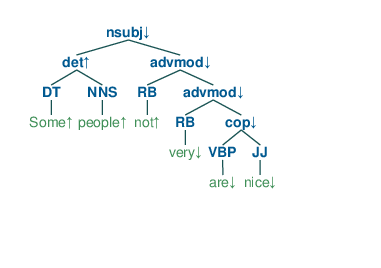

In [10]:
run_polarize_pipeline(["Some people aren't very nice"])



At most thirty five senators oppose the nomination.
At↑  most↑  thirty↑  five↑  senators↓  oppose↓  the↑  nomination=


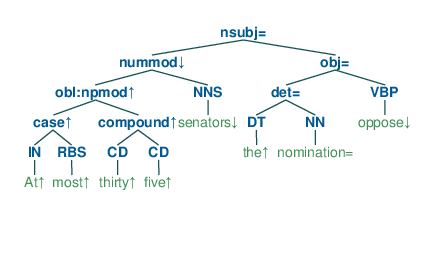



At least thirty five senators support the nomination
At↑  least↑  thirty↓  five↓  senators↑  support↑  the↑  nomination=


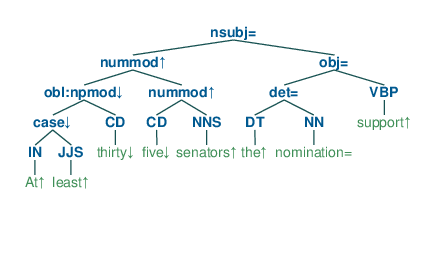



At most five senators oppose the nomination.
At↑  most↑  five↑  senators↓  oppose↓  the↑  nomination=


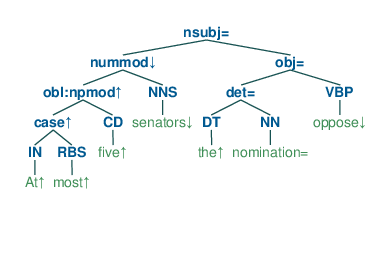



At least five senators support the nomination
At↑  least↑  five↓  senators↑  support↑  the↑  nomination=


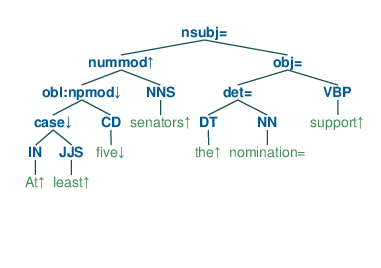



Some people who fear no animals face at least three lions
Some↑  people↑  who↑  fear↓  no↑  animals↓  face↑  at↑  least↑  three↓  lions↑


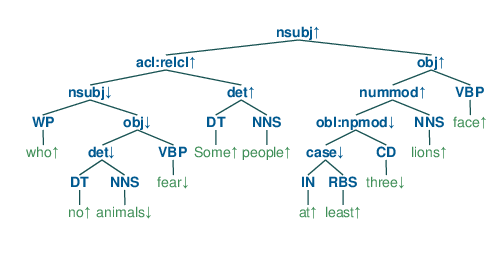



More than one out of six dentists had at least two cavities
More↓  than↓  one↓  out↓  of↓  six↓  dentists↑  had↑  at↑  least↑  two↓  cavities↑


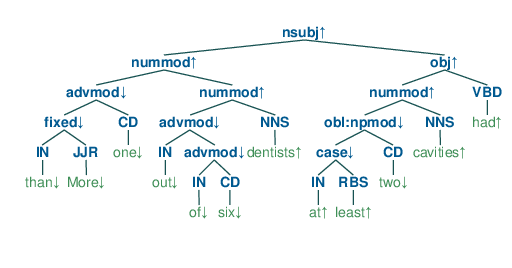



The old archer drank not less than six cups of mead 
The↑  old=  archer=  drank↓  not↑  less↓  than↓  six↓  cups↑  of↑  mead↑


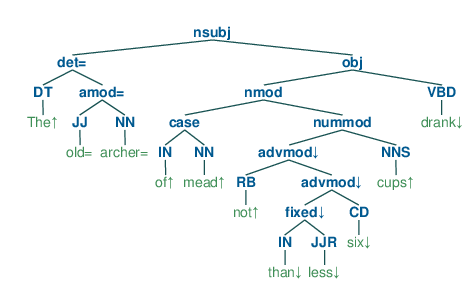

In [11]:
#### run_polarize_pipeline(["Jane gave three pens to every student who read all of Shakespeare's sonnets."], 2)
'''more than and as many as 
at most 
at least 
at most 
less than
only bears bance 
i only eat hot food'''
run_polarize_pipeline(["At most thirty five senators oppose the nomination.", 
                       "At least thirty five senators support the nomination", 
                       "At most five senators oppose the nomination.", 
                       "At least five senators support the nomination", 
                       "Some people who fear no animals face at least three lions",
                       "More than one out of six dentists had at least two cavities", 
                       "The old archer drank not less than six cups of mead "], verbose=0)
#run_polarize_pipeline(["At least 14 senators support the law", "At most 14 senators support the law", "At least 5 dogs sleep at night. ", "At most five dogs eat dinner.", "Some dogs eat no food"], 0)



Six cats slowly prowled two streets
Six=  cats↑  slowly↑  prowled↑  two↓  streets↑


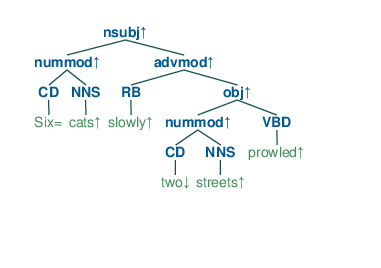



Five people can easily lift two pianos
Five=  people↑  can↑  easily↑  lift↑  two↓  pianos↑


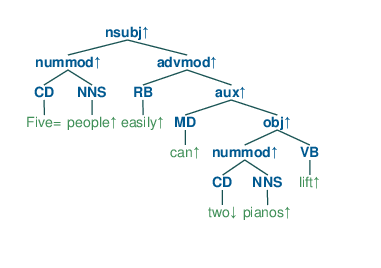



200 people happily ate 100 apples.
200=  people↑  happily↑  ate↑  100↓  apples↑


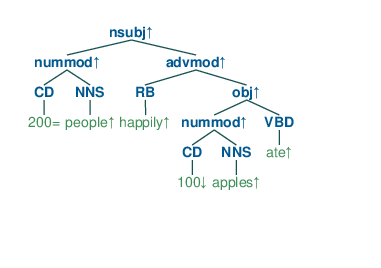



Jane gave three pens to every student who read all of Shakespeare's sonnets.
Jane↑  gave↑  three↓  pens↑  to↑  every↑  student↓  who↓  read↓  all  of=  Shakespeare↓  "s↓"  sonnets↓


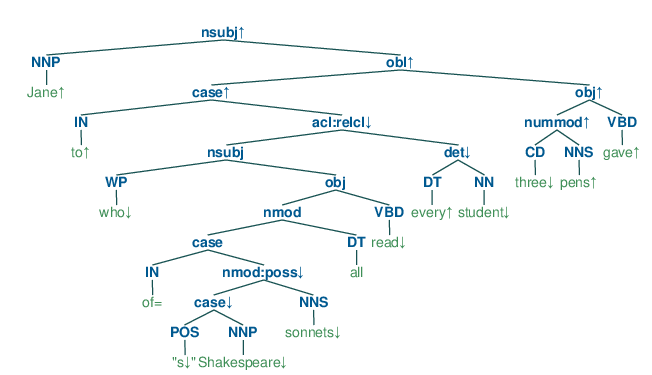

In [12]:
run_polarize_pipeline(["Six cats slowly prowled two streets", 
                       "Five people can easily lift two pianos",
                       "200 people happily ate 100 apples.", 
                       "Jane gave three pens to every student who read all of Shakespeare's sonnets."], verbose=0)



A million grasshoppers buzzed noisily

A↑  million↓  grasshoppers↑  buzzed↑  noisily↑


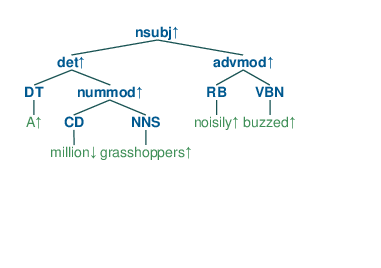



No plumber who wanted a job submitted an application

No↑  plumber↓  who↓  wanted↓  a↓  job↓  submitted↓  an↓  application↓


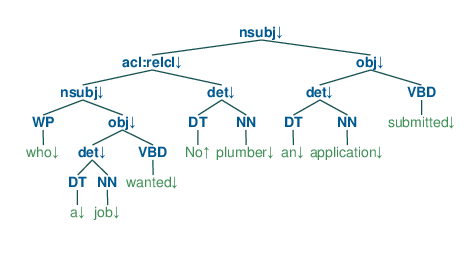



At most fourteen senators oppose

At↑  most↑  fourteen↓  senators↑  oppose↓


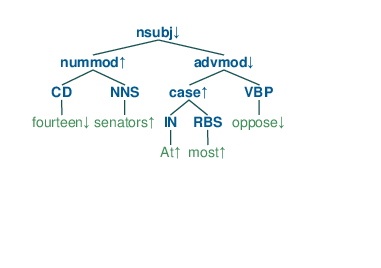



At least fourteen senators support

At↑  least↑  fourteen↓  senators↑  support↑


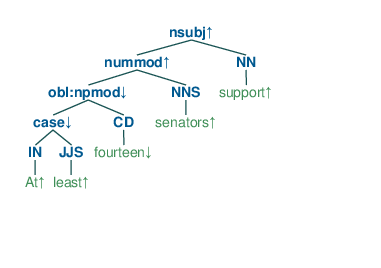



No carpenter or plumber attended the party

No↑  carpenter↓  or↑  plumber↓  attended↓  the↓  party=


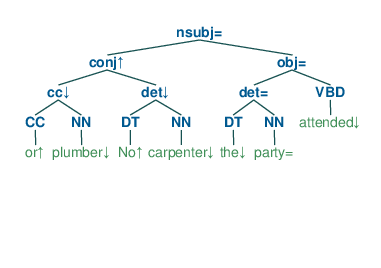



The large bones belonged to an Arapaho trader 

The↑  large=  bones=  belonged↑  to↑  an↑  Arapaho↑  trader↑


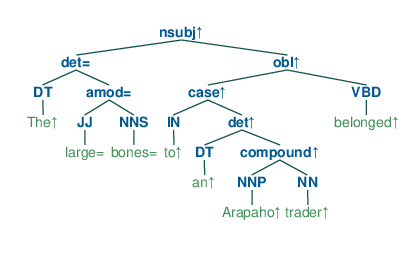



Every piano student who practices two hours a day makes progress

Every↑  piano↓  student↓  who↓  practices↓  two↑  hours↓  a↓  day↓  makes↑  progress↑


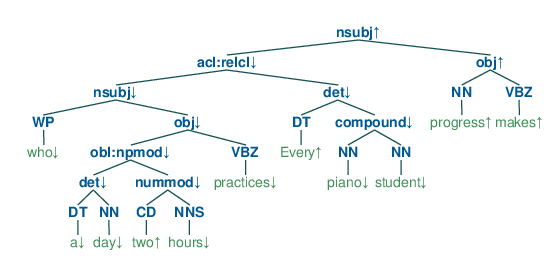



Five people can lift a piano

Five=  people↑  can↑  lift↑  a↑  piano↑


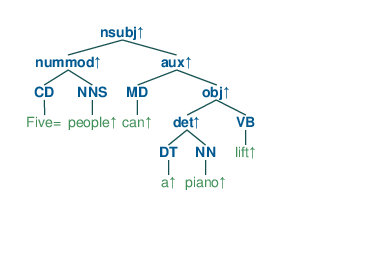



Not even six people can lift a three-ton weight

Not↑  even↑  six↑  people↓  can↓  lift↓  a↓  three↑  ton↑  weight↓


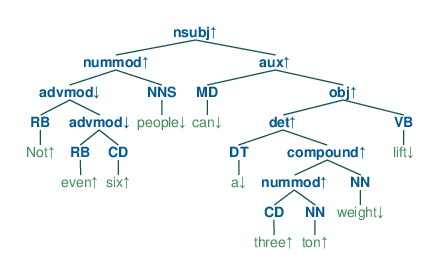



Every boy who played every sport got a gold medal

Every↑  boy↓  who↓  played↓  every↓  sport↑  got↑  a↑  gold↑  medal↑


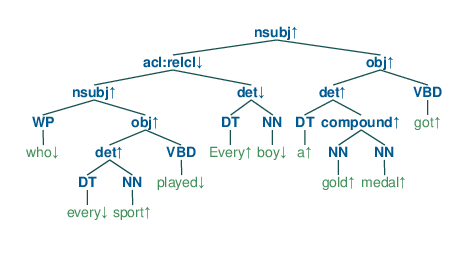



Some girl who played most sports flew to Florida

Some↑  girl↑  who↑  played↑  most↑  sports=  flew↑  to↑  Florida↑


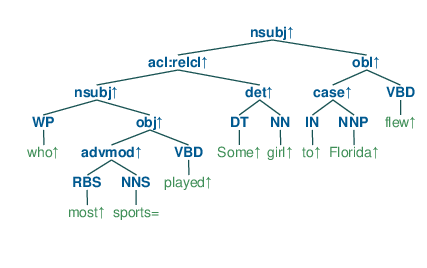



Anyone who has lived in Indiana likes persimmons

Anyone↑  who↑  has↑  lived↑  in↑  Indiana↓  likes↑  persimmons↑


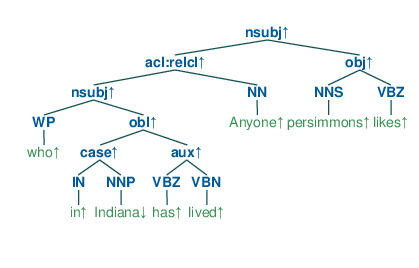



Dark black smoke wafted from the burned window frames

Dark↑  black↑  smoke↑  wafted↑  from↑  the↑  burned=  window=  frames=


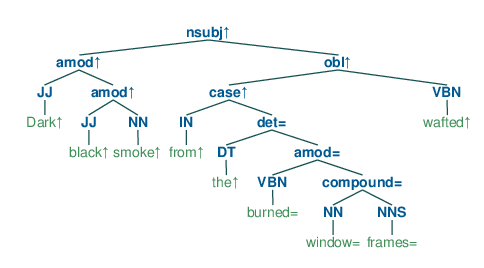



Six cats slowly prowled two streets

Six=  cats↑  slowly↑  prowled↑  two↓  streets↑


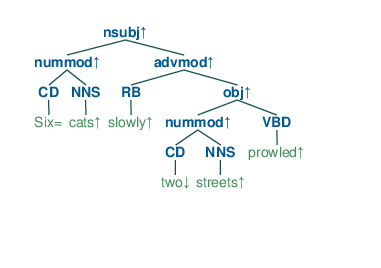



All people who love all people who love Mozart attended the concert

All↑  people↓  who↓  love↓  all↓  people↑  who↑  love↑  Mozart↑  attended↑  the↑  concert=


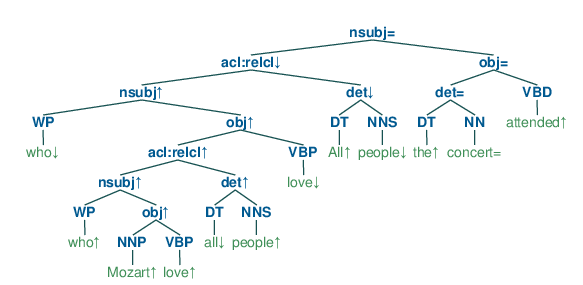



Some people who fear no animals face at least three lions

Some↑  people↑  who↑  fear↓  no↑  animals↓  face↑  at↑  least↑  three↓  lions↑


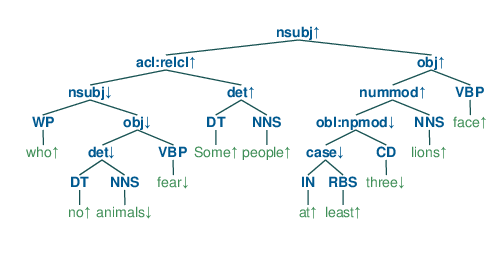



Some people who fear no ferocious animals jumped 

Some↑  people↑  who↑  fear↓  no↑  ferocious↓  animals↓  jumped↑


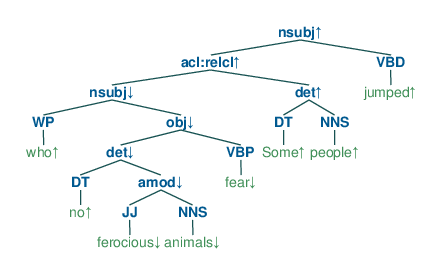



Jane gave three pens to every student who read all of Shakespeare's sonnets.

Jane↑  gave↑  three↓  pens↑  to↑  every↑  student↓  who↓  read↓  all  of=  Shakespeare↓  "s↓"  sonnets↓


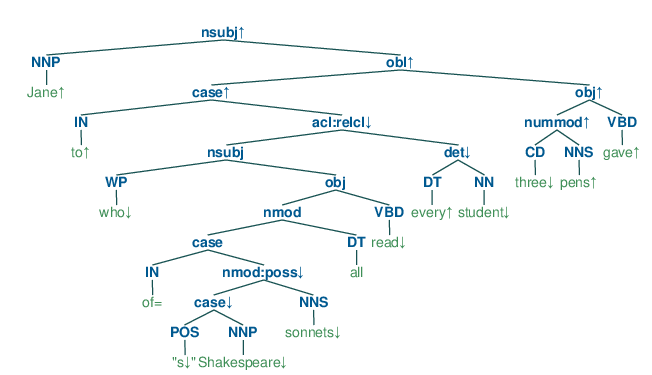



Most crows died of a rare disease

Most↑  crows=  died↑  of↑  a↑  rare↑  disease↑


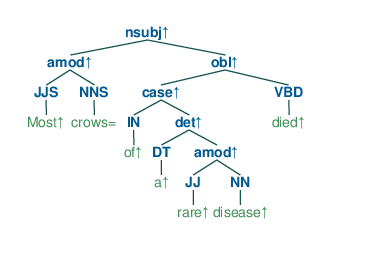



More than one out of six dentists had at least two cavities

More↓  than↓  one↓  out↓  of↓  six↓  dentists↑  had↑  at↑  least↑  two↓  cavities↑


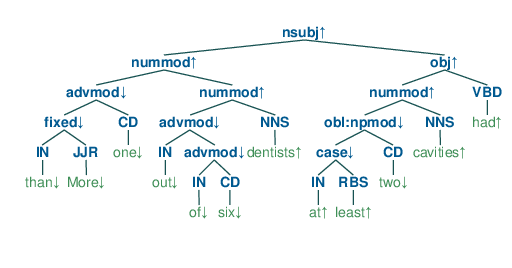



The old archer drank not less than six cups of mead 

The↑  old=  archer=  drank↓  not↑  less↓  than↓  six↓  cups↑  of↑  mead↑


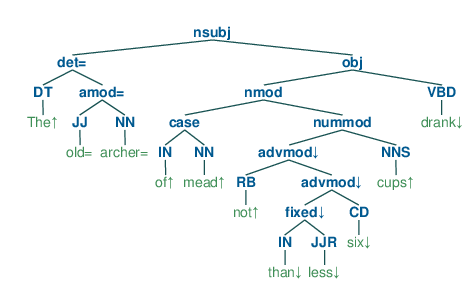



No newspapers reported no bad news

No↑  newspapers↓  reported↑  no↓  bad↑  news↑


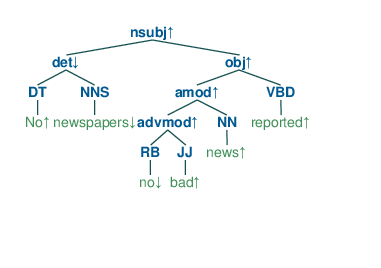



Some newspaper reported no bad news

Some↑  newspaper↑  reported↓  no↑  bad↓  news↓


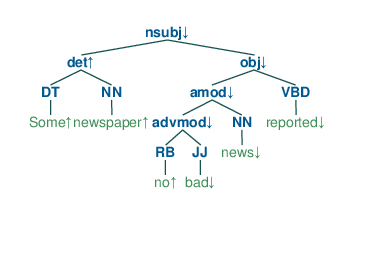



Most joggers turn left at every other corner

Most↑  joggers=  turn↑  left↑  at↑  every↑  other↓  corner↓


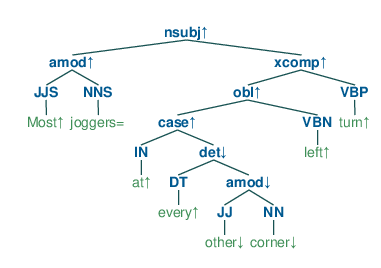

In [13]:
#filename = "monotonicity1.txt"
filename = "test_hard.txt"
valname = "test_hard.depccg.parsed.txt.polarized"
path = os.path.join('../data', filename)
val_path = os.path.join('../data', valname)
with open(path, 'r') as data:
    with open(val_path, 'r') as annotation:
        lines = data.readlines() 
        annotations = annotation.readlines()
        run_polarize_pipeline(lines, annotations, 0)
#run_polarize_pipeline(["The exchange came as Mr. Graham and Judge Barrett sought to push back on Democrats’ portrayal of the nominee as a right-wing activist chosen to undermine civil rights, the Affordable Care Act and environmental law."], 2)
#run_polarize_pipeline(["Republicans have instead worked to focus on her qualifications and emphasize her status as an accomplished working mother of seven."], 0)

In [ ]:
from nltk.corpus import wordnet as wn

emphasize = wn.synset('night.n.01')
print(emphasize.hypernyms())
print(emphasize.hyponyms())

In [ ]:
baseline = ["All dogs run", "Some dogs run", "No dog runs", 
            "All dogs eat apples", "Some dogs eat apples", "No dog eats apples", "That dog eats apples",
            "Many dogs sleep at night. ", "Most dogs sleep at night. ", "A few dogs sleep at night. ",
            "At least 5 dogs sleep at night. ", "At most five dogs eat dinner.","Five dogs are chasing cats",
            "All beautiful dogs eat apples", 
            "Some beautiful dogs eat apples", 
            "No beautiful dogs eat apples", 
            "All beautiful and smart dogs eat apples", 
            "No beautiful and smart dogs eat apples",
            "Some beautiful and smart dogs eat apples",
            "A smart and healthy person sleeps at night",
            "Every smart and healthy people sleep at night",
            "That tall and beautiful flower opens at night",
            "A man is playing the piano happily",
            "Every dog is excitedly chasing some cats",
            "No dog is excitedly chasing some cats",
            "All books here are beautifully printed and absolutely immaculate"]

Conservativity = ["No really great tenors are modest", "Some Italian tenors are great", 
              "The really ambitious tenors are Italian", "Each Italian tenors wants to be great",
              "Many great tenors are German", "Both leading tenors are excellent",
              "Neither leading tenor comes cheap",
              "At least three tenors will take part in the concert", 
              "At most two tenors will contribute their fees to charity", "One of the leading tenor is Pavarotti"
              "Leading tenors who are excellent are indispensable"]

monotonicity = ["An Irishman won the Nobel prize for literature.", "Every European has the right to live in Europe.", 
                "All Europeans have the right to live in Europe.", "Each European has the right to live in Europe.",
                "Every European is a person.",
                "Every person who has the right to live in Europe can travel freely within Europe.", 
                "An Italian became the world's greatest tenor"]

monotonicity_up_first = [
    "A Swede won a Nobel prize.",
    "Every Swede is a Scandinavian.",
    "A Scandinavian won a Nobel prize.",
    "Every Canadian resident can travel freely within Europe.",
    "Every Canadian resident is a resident of the North American continent.",
    "Every resident of the North American continent can travel freely within Europe.",
    "All Canadian residents can travel freely within Europe.",
    "Every Canadian resident is a resident of the North American continent.",
    "All residents of the North American continent can travel freely within Europe.",
    "Each Canadian resident can travel freely within Europe.",
    "Every Canadian resident is a resident of the North American continent.",
    "Each resident of the North American continent can travel freely within Europe.",
    "The residents of major western countries can travel freely within Europe.",
    "All residents of major western countries are residents of western countries.",
    "The residents of western countries have the right to live in Europe.",
    "No Scandinavian delegate finished the report on time.",
    "Some delegate finished the report on time.",
    "Some Irish delegates finished the survey on time.",
    "Some delegates finished the survey on time.",
    "Many British delegates obtained interesting results from the survey.",
    "Many delegates obtained interesting results from the survey.",
    "Several Portuguese delegates got the results published in major national newspapers.",
    "Several delegates got the results published in major national newspapers.",
    "Most Europeans who are resident in Europe can travel freely within Europe.",
    "Most Europeans can travel freely within Europe.",
    "A few female committee members are from Scandinavia.",
    "At least a few committee members are from Scandinavia.",
    "Few female committee members are from southern Europe.",
    "Few committee members are from southern Europe.",
    "Both female commissioners used to be in business.",
    "Neither female commissioner spends a lot of time at home.",
    "One of the commissioners spends a lot of time at home.",
    "At least three female commissioners spend time at home.",
    "At least three commissioners spend time at home.",
    "At most ten female commissioners spend time at home.",
    "At most ten commissioners spend time at home."
]

relative_clauses = ["Every boy who is loved by no person loves apples",
                    "Every boy who is loved by some people loves apples",
                    "Every boy who is loved by every person loves apples",
                    "Every boy who is loved by that person loves apples"]

In [2]:
from polarization import run_polarize_pipeline

In [ ]:
dataset = "sick"
filename = "sick_train.txt"
#valname = "test_hard.depccg.parsed.txt.polarized"
path = os.path.join('../data', dataset)
path = os.path.join(path, filename)
#val_path = os.path.join('../data', valname)
with open(path, 'r') as data:
    with open(val_path, 'r') as annotation:
        lines = data.readlines() 
        annotations = annotation.readlines()
        run_polarize_pipeline(lines, annotations, 0)

In [14]:
dataset = "sick"
filename = "sick_train.txt"
#valname = "test_hard.depccg.parsed.txt.polarized"
path = os.path.join('../data', dataset)
path = os.path.join(path, filename)
out_path = os.path.join('../data', dataset)
out_path = os.path.join(out_path, "sick.txt")

In [12]:
import pandas as pd

SICK_train = pd.read_table(path)
SICK_train.columns

Index(['pair_ID', 'sentence_A', 'sentence_B', 'relatedness_score',
       'entailment_judgment'],
      dtype='object')

In [13]:
import numpy as np 

sentence_A = SICK_train['sentence_A'].to_numpy()
sentence_B = SICK_train['sentence_B'].to_numpy()

In [15]:
with open(out_path, 'w') as filehandle:
    for listitem in sentence_A:
        filehandle.write('%s\n' % listitem)
    for listitem in sentence_B:
        filehandle.write('%s\n' % listitem)

In [16]:
dataset = "GLUE/glue_data/diagnostic"
filename = "diagnostic.tsv"
#valname = "test_hard.depccg.parsed.txt.polarized"
path = os.path.join('../data', dataset)
path = os.path.join(path, filename)
out_path = os.path.join('../data', dataset)
out_path = os.path.join(out_path, "diagnostic.txt")

In [17]:
diagnostic = pd.read_table(path)
diagnostic.columns

Index(['index', 'sentence1', 'sentence2'], dtype='object')

In [19]:
sentence1 = diagnostic['sentence1'].to_numpy()
sentence2 = diagnostic['sentence2'].to_numpy()

In [20]:
with open(out_path, 'w') as filehandle:
    for listitem in sentence1:
        filehandle.write('%s\n' % listitem)
    for listitem in sentence2:
        filehandle.write('%s\n' % listitem)

In [21]:
dataset = "GLUE/glue_data/SNLI"
filename = "train.tsv"
#valname = "test_hard.depccg.parsed.txt.polarized"
path = os.path.join('../data', dataset)
path = os.path.join(path, filename)
out_path = os.path.join('../data', dataset)
out_path = os.path.join(out_path, "snli_train.txt")

In [25]:
SNLI = pd.read_table(path, error_bad_lines=False)
SNLI.columns

ipping line 544217: expected 11 fields, saw 15\nSkipping line 544227: expected 11 fields, saw 14\nSkipping line 544246: expected 11 fields, saw 15\nSkipping line 544247: expected 11 fields, saw 15\nSkipping line 544251: expected 11 fields, saw 15\nSkipping line 544255: expected 11 fields, saw 15\nSkipping line 544275: expected 11 fields, saw 15\nSkipping line 544276: expected 11 fields, saw 15\nSkipping line 544277: expected 11 fields, saw 15\nSkipping line 544320: expected 11 fields, saw 15\nSkipping line 544328: expected 11 fields, saw 15\nSkipping line 544330: expected 11 fields, saw 15\nSkipping line 544332: expected 11 fields, saw 15\nSkipping line 544333: expected 11 fields, saw 15\nSkipping line 544334: expected 11 fields, saw 15\nSkipping line 544337: expected 11 fields, saw 15\nSkipping line 544340: expected 11 fields, saw 15\nSkipping line 544344: expected 11 fields, saw 15\nSkipping line 544345: expected 11 fields, saw 15\nSkipping line 544348: expected 11 fields, saw 15\nSk

Index(['index', 'captionID', 'pairID', 'sentence1_binary_parse',
       'sentence2_binary_parse', 'sentence1_parse', 'sentence2_parse',
       'sentence1', 'sentence2', 'label1', 'gold_label'],
      dtype='object')

In [26]:
sentence1 = SNLI['sentence1'].to_numpy()
sentence2 = SNLI['sentence2'].to_numpy()

In [27]:
with open(out_path, 'w') as filehandle:
    for listitem in sentence1:
        filehandle.write('%s\n' % listitem)
    for listitem in sentence2:
        filehandle.write('%s\n' % listitem)